In [2]:
# Step 0: imports & basic settings
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# optional: faster visual embedding
try:
    import umap.umap_ as umap
    UMAP_AVAILABLE = True
except Exception:
    UMAP_AVAILABLE = False

import joblib
sns.set(style="whitegrid", palette="muted", font_scale=1.0)
RANDOM_STATE = 42


In [3]:
# Step 1: load file
DATA_PATH = "/content/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv"
df = pd.read_csv(DATA_PATH)

# Quick peek
print("Shape:", df.shape)
display(df.head(5))
print("\nColumns:", df.columns.tolist())
print("\nMissing values (descending):")
display(df.isna().sum().sort_values(ascending=False).head(30))

Shape: (7787, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...



Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']

Missing values (descending):


,0
director,2389
cast,718
country,507
date_added,10
rating,7
title,0
show_id,0
type,0
release_year,0
duration,0


In [4]:
# Step 2: basic cleaning
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip().replace({'nan':'', 'None':''})

# Put original NaNs back where appropriate (we'll handle key columns below)
df.replace({'': np.nan}, inplace=True)

# Convert date_added to datetime (may create NaT)
if 'date_added' in df.columns:
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Quick check again
display(df.head(3))
print(df.dtypes)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."


show_id                 object
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
dtype: object


In [5]:
# Step 3: Fill / mark missing values

# 1) Metadata columns -> 'Unknown'
text_fill_unknown = ['country','director','cast']
for col in text_fill_unknown:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# 2) Important text fields: keep missing indicator, but fill for processing
for col in ['title','description']:
    if col in df.columns:
        df[f'{col}_missing'] = df[col].isna().astype(int)   # indicator
        df[col] = df[col].fillna('')                        # fill empty string to allow vectorizers

# 3) rating -> 'Not Rated'
if 'rating' in df.columns:
    df['rating'] = df['rating'].fillna('Not Rated')

# 4) date_added -> keep NaT but make indicator & added_year
if 'date_added' in df.columns:
    df['date_added_missing'] = df['date_added'].isna().astype(int)
    df['date_added_year'] = df['date_added'].dt.year.fillna(0).astype(int)

# 5) release_year numeric -> median
if 'release_year' in df.columns:
    df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')
    df['release_year'] = df['release_year'].fillna(int(df['release_year'].median()))

# Final missing-value summary
print("Missing values after filling / marking:")
display(df.isna().sum().sort_values(ascending=False).head(30))


Missing values after filling / marking:


,0
date_added,10
show_id,0
title,0
type,0
director,0
cast,0
country,0
release_year,0
rating,0
duration,0


In [8]:
# Step 4: parse duration into duration_minutes and num_seasons
def extract_minutes(x):
    if pd.isna(x): return np.nan
    s = str(x)
    if re.search(r'[Ss]eason', s):
        return np.nan
    m = re.search(r'(\d+)', s)
    return int(m.group(1)) if m else np.nan

def extract_seasons(x):
    if pd.isna(x): return 0
    s = str(x)
    if re.search(r'[Ss]eason', s):
        m = re.search(r'(\d+)', s)
        return int(m.group(1)) if m else 0
    return 0

if 'duration' in df.columns:
    df['duration_minutes'] = df['duration'].apply(extract_minutes)
    df['num_seasons'] = df['duration'].apply(extract_seasons)

# create flag if this is a TV show (depending on your 'type' values)
if 'type' in df.columns:
    df['is_tv'] = df['type'].str.lower().eq('tv show') | df['type'].str.lower().eq('tv')
else:
    df['is_tv'] = 0

# Cast numeric columns to numeric & fill NA with sensible values for modeling
df['duration_minutes'] = pd.to_numeric(df.get('duration_minutes', pd.Series(np.nan)), errors='coerce').fillna(0)
df['num_seasons'] = pd.to_numeric(df.get('num_seasons', pd.Series(0)), errors='coerce').fillna(0)


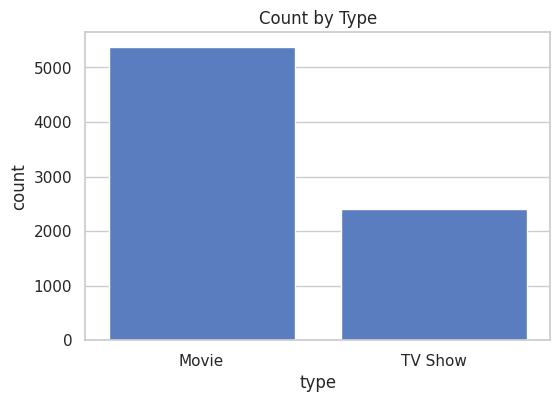

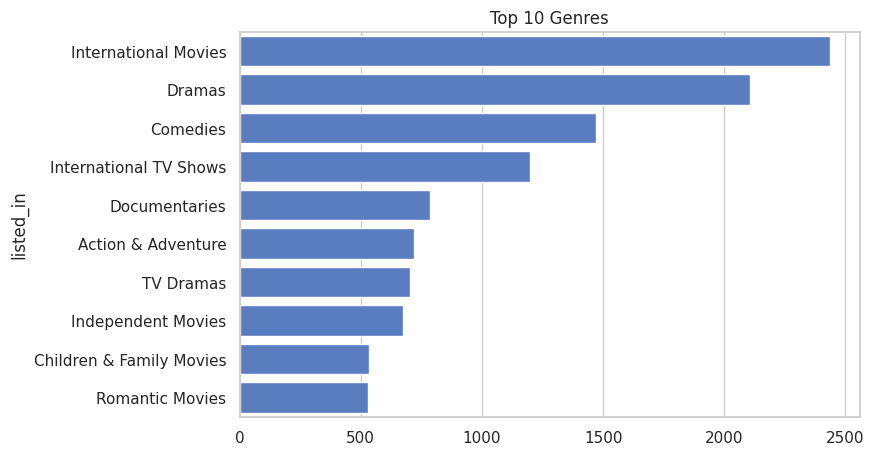

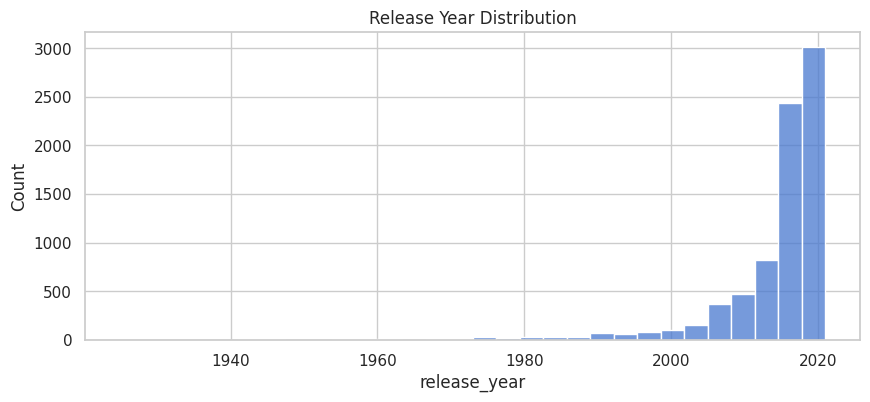

In [9]:
# Step 5: quick visual checks
plt.figure(figsize=(6,4))
if 'type' in df.columns:
    sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
    plt.title("Count by Type")
    plt.show()

if 'listed_in' in df.columns:
    genres = df['listed_in'].fillna('').str.split(',').explode().str.strip()
    top_genres = genres.value_counts().head(10)
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_genres.values, y=top_genres.index)
    plt.title("Top 10 Genres")
    plt.show()

if 'release_year' in df.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(df['release_year'].dropna(), bins=30)
    plt.title("Release Year Distribution")
    plt.show()


In [10]:
# Step 6: feature engineering

# A) num_cast
if 'cast' in df.columns:
    df['num_cast'] = df['cast'].apply(lambda x: len(str(x).split(',')) if x and x != 'Unknown' else 0)
else:
    df['num_cast'] = 0

# B) genres -> MultiLabelBinarizer
if 'listed_in' in df.columns:
    genres_series = df['listed_in'].fillna('').str.split(',').apply(lambda L: [g.strip() for g in L if g.strip()])
else:
    genres_series = pd.Series([[]]*len(df))
mlb = MultiLabelBinarizer(sparse_output=False)
X_genres = mlb.fit_transform(genres_series)   # shape = (n_samples, n_genre_labels)

# C) Text TF-IDF (title + description)
text_data = (df['title'].fillna('') + ' ' + df['description'].fillna('')).astype(str)
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2), stop_words='english')
X_text = tfidf.fit_transform(text_data)   # sparse matrix

# D) Reduce text dimensionality for speed (TruncatedSVD)
svd_n_components = 50
svd = TruncatedSVD(n_components=svd_n_components, random_state=RANDOM_STATE)
X_text_reduced = svd.fit_transform(X_text)   # dense array shape (n_samples, svd_n_components)

# E) Numeric features
num_df = pd.DataFrame({
    'release_year': df.get('release_year', pd.Series(0)).fillna(0).astype(float),
    'duration_minutes': df.get('duration_minutes', pd.Series(0)).fillna(0).astype(float),
    'num_seasons': df.get('num_seasons', pd.Series(0)).fillna(0).astype(float),
    'num_cast': df['num_cast'].astype(float),
    'is_tv': df['is_tv'].astype(int)
})
scaler = StandardScaler()
X_num = scaler.fit_transform(num_df)

# F) Final feature matrix
X = np.hstack([X_text_reduced, X_genres, X_num])
print("Feature matrix shape:", X.shape)


Feature matrix shape: (7787, 97)


In [11]:
# Step 7: choose K
def find_best_k(X, k_range=range(2,11), sample_size=3000):
    n = X.shape[0]
    if n > sample_size:
        rng = np.random.RandomState(RANDOM_STATE)
        idx = rng.choice(n, sample_size, replace=False)
        X_eval = X[idx]
    else:
        X_eval = X
    scores = {}
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
        labels = km.fit_predict(X_eval)
        scores[k] = silhouette_score(X_eval, labels)
        print(f"K={k}, silhouette={scores[k]:.4f}")
    return scores

scores = find_best_k(X, range(2,11))
best_k = max(scores, key=scores.get)
print("Best k:", best_k)


K=2, silhouette=0.3905
K=3, silhouette=0.3783
K=4, silhouette=0.2388
K=5, silhouette=0.2635
K=6, silhouette=0.2266
K=7, silhouette=0.1941
K=8, silhouette=0.1901
K=9, silhouette=0.1863
K=10, silhouette=0.1847
Best k: 2


In [12]:
# Step 8: final KMeans clustering on full X
best_k = int(best_k)
km_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
df['cluster'] = km_final.fit_predict(X)

# Save model & transformers for reproducibility
os.makedirs("models", exist_ok=True)
joblib.dump(tfidf, "models/tfidf.joblib")
joblib.dump(svd, "models/svd.joblib")
joblib.dump(mlb, "models/mlb.joblib")
joblib.dump(scaler, "models/scaler.joblib")
joblib.dump(km_final, "models/kmeans.joblib")

print("Clusters assigned. Cluster counts:")
display(df['cluster'].value_counts().sort_index())


Clusters assigned. Cluster counts:


,count
cluster,
0,5377
1,2410


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


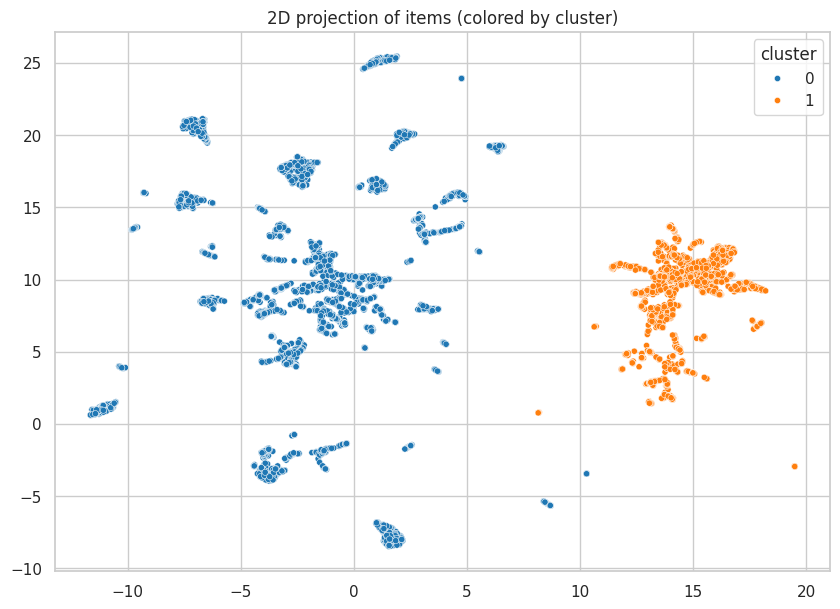

In [13]:
# Step 9: embed to 2D for visualization
if UMAP_AVAILABLE:
    embed = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
    X2 = embed.fit_transform(X)
else:
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=40, n_iter=1000)
    X2 = tsne.fit_transform(X)

plt.figure(figsize=(10,7))
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=df['cluster'], legend='full', s=20, palette='tab10')
plt.title("2D projection of items (colored by cluster)")
plt.show()


In [14]:
# Step 10A: top genres per cluster
genres_exploded = df[['cluster','listed_in']].assign(
    listed_in=df['listed_in'].fillna('').str.split(',')
).explode('listed_in')
genres_exploded['listed_in'] = genres_exploded['listed_in'].str.strip().replace('', np.nan)
top_genres = genres_exploded.groupby('cluster')['listed_in'].value_counts().groupby(level=0).head(5)
print("Top genres per cluster:")
display(top_genres)

# Step 10B: top TF-IDF terms per cluster (use original X_text sparse matrix)
feature_names = tfidf.get_feature_names_out()
cluster_top_terms = {}
for c in sorted(df['cluster'].unique()):
    idx = df.index[df['cluster'] == c].tolist()
    if len(idx) == 0:
        cluster_top_terms[c] = []
        continue
    # mean tfidf vector of cluster members
    mean_vec = np.asarray(X_text[idx].mean(axis=0)).ravel()
    topn = mean_vec.argsort()[-10:][::-1]
    cluster_top_terms[c] = [(feature_names[i], mean_vec[i]) for i in topn]
    print(f"\nCluster {c} top words: {[t[0] for t in cluster_top_terms[c]]}")

# Step 10C: numeric summaries and sample titles
cluster_profiles = []
for c in sorted(df['cluster'].unique()):
    part = df[df['cluster']==c]
    profile = {
        'cluster': c,
        'n_items': len(part),
        'avg_release_year': float(part['release_year'].mean()),
        'avg_duration_minutes': float(part['duration_minutes'].replace(0, np.nan).dropna().mean() if 'duration_minutes' in part else np.nan),
        'top_titles_sample': list(part['title'].dropna().head(5).values)
    }
    cluster_profiles.append(profile)

cluster_profiles_df = pd.DataFrame(cluster_profiles)
display(cluster_profiles_df.sort_values('n_items', ascending=False))


Top genres per cluster:


cluster  listed_in             
0        International Movies      2437
         Dramas                    2106
         Comedies                  1471
         Documentaries              786
         Action & Adventure         721
1        International TV Shows    1199
         TV Dramas                  704
         TV Comedies                525
         Crime TV Shows             427
         Kids' TV                   414
Name: count, dtype: int64


Cluster 0 top words: ['life', 'young', 'man', 'new', 'family', 'love', 'woman', 'documentary', 'world', 'father']

Cluster 1 top words: ['series', 'world', 'life', 'love', 'new', 'friends', 'family', 'young', 'school', 'high']


,cluster,n_items,avg_release_year,avg_duration_minutes,top_titles_sample
0,0,5377,2012.920030,99.307978,"[7:19, 23:59, 9, 21, 122]"
1,1,2410,2016.191701,NaN,"[3%, 46, 1983, 1994, Feb-09]"


In [15]:
# Step 11: Save full labeled dataset
df.to_csv("netflix_clustered.csv", index=False)
print("Saved: netflix_clustered.csv (contains cluster column)")

# Models saved previously in /models
print("Saved models in ./models: tfidf, svd, mlb, scaler, kmeans")


Saved: netflix_clustered.csv (contains cluster column)
Saved models in ./models: tfidf, svd, mlb, scaler, kmeans
